In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [2]:
test_df = pd.read_csv('test.csv')

In [3]:
train_df = pd.read_csv('train.csv')

## Fare 결측치 처리(Test 데이터에만 처리해야하여 따로 처리)

In [4]:
# 'Pclass'가 3이고, 'Sex'가 남자이며, 동승자가 없는 그룹의 'Fare' 중앙값 계산
med_fare = test_df[(test_df['Pclass'] == 3) & (test_df['Sex'] == 'male') & (test_df['SibSp'] == 0) & (test_df['Parch'] == 0)]['Fare'].median()

# 'Fare' 결측치를 해당 그룹의 중앙값으로 채우기
test_df['Fare'].fillna(med_fare, inplace=True)

## 전처리 함수

In [5]:
def make_cabin(dataset):
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    
    return dataset
  
def make_title(dataset) :
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    return dataset

def change_title(dataset):
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    return dataset
  
def title_map(dataset):
    titlemap = {'Master':1,'Mr': 2, 'Miss': 3, 'Mrs': 4, 'other': 5}
    dataset['Title'] = dataset['Title'].map(titlemap)
    dataset['Title'] = dataset['Title'].fillna(0)

    return dataset

def make_deck(dataset):
    dataset['Deck'] = dataset['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'Z')
    train_df['Deck'] = train_df['Deck'].replace('T','A')
    train_df['Embarked'] = train_df['Embarked'].fillna('S')

    return dataset
    
## 실제 데이터와의 대조를 통해 Embarked열의 훈련데이터에 결측치 대체
def Agefill(dataset):
    # 'Pclass'와 'Sex'로 그룹화하고, 각 그룹의 'Age' 중앙값으로 결측치를 채웁니다.
    dataset['Age'] = dataset.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    return dataset
    
def AgeGroup(dataset):
    bins = [0, 10, 20, 30, 40, 50, 60, 81]
    labels = [0,1,2,3,4,5,6]
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=bins, labels=labels, right=True)

    return dataset

def AgeClass(dataset):
    dataset['AgeClass'] = dataset['Age'] * dataset['Pclass']

    return dataset
    
def fam(dataset):    
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    bins = [0, 1, 5, 7, np.inf]  # np.inf는 무한대를 의미합니다.
    labels = ['Single', 'Small', 'Medium', 'Large']  # 각 구간에 대한 라벨
    dataset['Family_Size_Class'] = pd.cut(dataset['FamilySize'], bins=bins, labels=labels)

    return dataset
    
def isalone(dataset):
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    return dataset

def transform_features(dataset):

    dataset = make_cabin(dataset)
    dataset = make_title(dataset)
    dataset = change_title(dataset)
    dataset = title_map(dataset)
    dataset = make_deck(dataset)
    dataset = Agefill(dataset)
    dataset = AgeGroup(dataset)
    dataset = AgeClass(dataset)
    dataset = fam(dataset)
    dataset = isalone(dataset)
    
    return dataset
    
train_df = transform_features(train_df)
test_df = transform_features(test_df)

## 훈련, 테스트 세트에서 Fare 열의 구간 나누기

In [6]:
# 훈련 세트에서 'Fare'의 qcut 범위를 학습하고 적용합니다.
train_df['Fare_cat'] = pd.qcut(train_df['Fare'], q=8)
fare_bins = pd.qcut(train_df['Fare'], q=8, retbins=True)[1]

# 학습한 범위를 평가 세트에 적용합니다.
test_df['Fare_cat'] = pd.cut(test_df['Fare'], bins=fare_bins, include_lowest=True)

In [7]:
train_df['AgeGroup'] = train_df['AgeGroup'].astype(int)
test_df['AgeGroup'] = test_df['AgeGroup'].astype(int)

## 범주형 변수 원핫인코딩하기

In [8]:
# prefix 파라미터는 생성된 더미 컬럼에 접두사를 추가하는데 사용됩니다.
#범주형변수 원핫인코딩하기
data_frames = [train_df, test_df]

for i in range(len(data_frames)):
    data_frames[i] = pd.get_dummies(data_frames[i], columns=['Embarked', 'Sex', 'Title', 'Pclass', 'Family_Size_Class'], 
                        prefix=['Emb', 'Sex', 'Title', 'Pclass', 'FamSizeClass'])

train_df, test_df = data_frames

## 숫자형 변수의 표준화

In [9]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train_df[['AgeClass','Fare']] = std_scaler.fit_transform(train_df[['AgeClass','Fare']])
test_df[['AgeClass','Fare']] = std_scaler.transform(test_df[['AgeClass','Fare']])

## X_train, X_test, y_train
## X_sub, X_val, y_sub, y_val 분리

In [10]:
from sklearn.model_selection import train_test_split

X_train = train_df.drop(['PassengerId','Survived','IsAlone','Name', 'Age', 'SibSp','Parch','Deck' ,'IsAlone','Ticket', 'Cabin' ,'Fare_cat', 'FamilySize'],axis=1)
X_test  = test_df.drop(['PassengerId','IsAlone','Name', 'Age', 'SibSp','Parch' ,'IsAlone','Deck','Ticket', 'Cabin' ,'Fare_cat', 'FamilySize'],axis=1)
y_train = train_df['Survived']
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

## 베이스라인 모델

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# # 모델 초기화
# dt = DecisionTreeClassifier(random_state = 42)
# knn_classifier = KNeighborsClassifier(n_neighbors=5)
# rf = RandomForestClassifier(random_state = 42)
lr = LogisticRegression(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
# et = ExtraTreesClassifier(random_state=42)
# svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
# # Decision Tree
# dt.fit(X_sub, y_sub)
# dt_predictions = dt.predict(X_val)
# # K-Nearest Neighbors
# knn_classifier.fit(X_sub, y_sub)
# knn_predictions = knn_classifier.predict(X_val)

# # Random Forest
# rf.fit(X_sub, y_sub)
# rf_predictions = rf.predict(X_val)

# Logistic Regression
lr.fit(X_sub, y_sub)
lr_predictions = lr.predict(X_val)

# LightGBM
lgb.fit(X_sub, y_sub)
lgb_predictions = lgb.predict(X_val)

# XGBoost
xgb.fit(X_sub, y_sub)
xgb_predictions = xgb.predict(X_val)

# # Extra Trees
# et.fit(X_sub, y_sub)
# et_predictions = et.predict(X_val)

# # Support Vector Machine
# svm_classifier.fit(X_sub, y_sub)
# svm_predictions = svm_classifier.predict(X_val)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

## 베이스라인 모델 accuracy 구하기

In [12]:
# accuracy1 = accuracy_score(y_val, dt_predictions)
# accuracy2 = accuracy_score(y_val, knn_predictions)
# accuracy3 = accuracy_score(y_val, rf_predictions)
accuracy4 = accuracy_score(y_val, lr_predictions)
accuracy5 = accuracy_score(y_val, lgb_predictions)
accuracy6 = accuracy_score(y_val, xgb_predictions)
# accuracy7 = accuracy_score(y_val, et_predictions)
# accuracy8 = accuracy_score(y_val, svm_predictions)


print(accuracy4);print(accuracy5);print(accuracy6)

0.7988826815642458
0.8547486033519553
0.8100558659217877


## 맷플롯립 폰트설정 바꿔서 에러 없앰

In [13]:
plt.rcParams['font.family'] = 'DejaVu Sans'

## 베이스라인 모델 roc커브 시각화

In [14]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# # 각 모델에 대한 예측 확률 계산
# xgb_proba = xgb.predict_proba(X_val)[:, 1]
# lgb_proba = lgb.predict_proba(X_val)[:, 1]
# lr_proba = lr.predict_proba(X_val)[:, 1]

# # ROC 커브 계산
# fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_proba)
# fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgb_proba)
# fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba)

# # AUC 점수 계산
# auc_xgb = roc_auc_score(y_val, xgb_proba)
# auc_lgb = roc_auc_score(y_val, lgb_proba)
# auc_lr = roc_auc_score(y_val, lr_proba)

# # ROC 커브 시각화
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.5f)' % auc_xgb)
# plt.plot(fpr_lgb, tpr_lgb, label='LightGBM (AUC = %0.5f)' % auc_lgb)
# plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.5f)' % auc_lr)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curves')
# plt.legend(loc="lower right")
# plt.show()

## 베이스라인 모델 혼동 행렬 시각화

In [15]:
# from sklearn.metrics import confusion_matrix

# # 혼동 행렬 계산
# cm_xgb = confusion_matrix(y_val, xgb_predictions)
# cm_lgb = confusion_matrix(y_val, lgb_predictions)
# cm_lr = confusion_matrix(y_val, lr_predictions)

# # 혼동 행렬 시각화 (XGBoost)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion matrix for XGBoost')
# plt.ylabel('Actual class')
# plt.xlabel('Predicted class')
# plt.show()

# # 혼동 행렬 시각화 (LightGBM)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion matrix for LightGBM')
# plt.ylabel('Actual class')
# plt.xlabel('Predicted class')
# plt.show()

# # 혼동 행렬 시각화 (Logistic Regression)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion matrix for Logistic Regression')
# plt.ylabel('Actual class')
# plt.xlabel('Predicted class')
# plt.show()

## 베이스라인 모델 특성중요도 및 로지스틱회귀의 경우 회귀계수 시각화

In [16]:
# # 특성 이름과 계수를 모두 포함하는 DataFrame을 만듭니다.
# feature_importance = pd.DataFrame({"feature": X_val.columns, "importance": lr.coef_[0]})

# # 중요도에 따라 특성을 정렬합니다.
# feature_importance = feature_importance.sort_values("importance", ascending=False)

# print(feature_importance)

In [17]:
# # XGBoost feature importance
# xgb_feature_importance = pd.DataFrame({"feature": X_val.columns, "importance": xgb.feature_importances_})
# xgb_feature_importance = xgb_feature_importance.sort_values("importance", ascending=False)
# print(xgb_feature_importance)

In [18]:
# # LightGBM feature importance
# lgb_feature_importance = pd.DataFrame({"feature": X_val.columns, "importance": lgb.feature_importances_})
# lgb_feature_importance = lgb_feature_importance.sort_values("importance", ascending=False)
# print(lgb_feature_importance)

In [19]:
# # 로지스틱 회귀 피처 중요도 시각화
# plt.figure(figsize=(10, 8))
# sns.barplot(x="importance", y="feature", data=feature_importance)
# plt.title('Logistic Regression feature importance')
# plt.show()

In [20]:
# # XGBoost feature importance
# plt.figure(figsize=(10, 8))
# sns.barplot(x="importance", y="feature", data=xgb_feature_importance)
# plt.title('XGBoost feature importance')
# plt.show()

In [21]:
# # LightGBM feature importance
# plt.figure(figsize=(10, 8))
# sns.barplot(x="importance", y="feature", data=lgb_feature_importance)
# plt.title('LightGBM feature importance')
# plt.show()

In [22]:
# import numpy as np

# # 가정: feature_names는 feature들의 이름을 담고 있는 리스트
# feature_names = list(X_train.columns)

# extra_tree_importances = et.feature_importances_
# decision_tree_importances = dt.feature_importances_
# random_forest_importances = rf.feature_importances_
# # Feature importances를 numpy array로 변환
# extra_tree_importances = np.array(extra_tree_importances)
# decision_tree_importances = np.array(decision_tree_importances)
# random_forest_importances = np.array(random_forest_importances)

# # Bar 위치 설정
# x = np.arange(len(feature_names))

# # Bar 차트 그리기
# plt.figure(figsize=(14, 6))
# plt.bar(x - 0.2, extra_tree_importances, 0.2, label='ExtraTrees')
# plt.bar(x, decision_tree_importances, 0.2, label='DecisionTree')
# plt.bar(x + 0.2, random_forest_importances, 0.2, label='RandomForest')

# # x축 레이블 설정
# plt.xticks(ticks=x, labels=feature_names, rotation=45)

# # 범례 추가
# plt.legend()

# #

In [23]:
# # 가정: feature_names는 feature들의 이름을 담고 있는 리스트

# # feature importance를 담은 DataFrame을 생성
# df_importance = pd.DataFrame({'feature': feature_names, 'importance': extra_tree_importances})

# # importance 기준으로 내림차순 정렬
# df_importance.sort_values('importance', ascending=False)



In [24]:
# # 가정: feature_names는 feature들의 이름을 담고 있는 리스트

# # feature importance를 담은 DataFrame을 생성
# df_importance = pd.DataFrame({'feature': feature_names, 'importance': decision_tree_importances})

# # importance 기준으로 내림차순 정렬
# df_importance.sort_values('importance', ascending=False)


In [25]:
# # 가정: feature_names는 feature들의 이름을 담고 있는 리스트

# # feature importance를 담은 DataFrame을 생성
# df_importance = pd.DataFrame({'feature': feature_names, 'importance': random_forest_importances})

# # importance 기준으로 내림차순 정렬
# df_importance.sort_values('importance', ascending=False)


## 랜덤 포레스트 랜덤서치 교차검증 

In [26]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.tree import ExtraTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from scipy.stats import randint
# from sklearn.model_selection import train_test_split
# # Decision Tree 모델 생성
# etc = ExtraTreeClassifier(random_state=42)

# # RandomForest 모델 생성
# rf = RandomForestClassifier(random_state=42)

# # ExtraTree 랜덤서치 파라미터 그리드 설정
# # 파라미터 그리드 생성
# param_grid = {
#     'max_depth': [2, 3, 5, 10, 20],  # None 또는 5, 10, 20 중 하나 선택
#     'min_samples_split': randint(2, 20),  # 2에서 20 사이의 값을 랜덤하게 선택
#     'min_samples_leaf': randint(1, 10),  # 1에서 10 사이의 값을 랜덤하게 선택
#     'max_features': ['sqrt', 'log2']  # 'auto', 'sqrt', 'log2' 중 하나 선택
# }


# # RandomForest 랜덤서치 파라미터 그리드 설정
# rf_param_grid = {
#     'n_estimators': randint(100, 1000),
#     'criterion': ['gini', 'entropy'],
#     'max_depth': randint(1, 10),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'max_features': ['sqrt', 'log2']
# }
# # 데이터를 훈련 세트와 검증 세트로 분할
# X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Extra Tree 랜덤서치 수행
# etc_random_search = RandomizedSearchCV(etc, param_distributions=param_grid, n_jobs = -1, n_iter=10, cv=5,random_state=42)
# etc_random_search.fit(X_train_sub, y_train_sub)

# # RandomForest 랜덤서치 수행
# rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_param_grid, n_jobs= -1, n_iter=10, cv=5,random_state=42)
# rf_random_search.fit(X_train_sub, y_train_sub)

# # Extra Tree 예측 및 평가
# etc_pred = etc_random_search.predict(X_val)
# etc_score = etc_random_search.score(X_val , y_val)
# print("Extra Tree 평가 점수:", etc_score)

# # RandomForest 예측 및 평가
# rf_pred = rf_random_search.predict(X_val)
# rf_score = rf_random_search.score(X_val, y_val)
# print("Random Forest 평가 점수:", rf_score)

## 랜덤서치로 XGBoost 기반 교차검증 및 최적의 하이퍼 파라미터 찾기

In [27]:
# Define the parameter grid
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)

# Initialize the Random Search
xgb_random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, cv=5,random_state=42)

# Fit the random search model
xgb_random_search.fit(X_sub, y_sub)

# Get the best parameters
best_params = xgb_random_search.best_params_

print("Best parameters: ", best_params)

xgbpred = xgb_random_search.predict(X_val)
accuracy = accuracy_score(y_val, xgbpred)
print("val Set Accuracy Score: ", accuracy)

Best parameters:  {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.4}
val Set Accuracy Score:  0.8268156424581006


In [28]:
# from scipy.stats import randint

# # Define the parameter grid
# param_grid = {
#     'max_depth': randint(1, 50),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 20),
#     'criterion': ['gini', 'entropy']
# }

# # Initialize the Decision Tree classifier
# dtc = DecisionTreeClassifier(random_state=42)

# # Initialize the Random Search
# dtc_random_search = RandomizedSearchCV(dtc, param_distributions=param_grid, cv=5, n_iter=100, random_state=42)

# # Fit the random search model
# dtc_random_search.fit(X_train_sub, y_train_sub)

# # Get the best parameters
# best_params = dtc_random_search.best_params_

# print("Best parameters: ", best_params)
# dtcpred = dtc_random_search.predict(X_val)
# accuracy = accuracy_score(y_val, dtcpred)
# print("val Set Accuracy Score: ", accuracy)

## 교차검증으로 찾은 최적의 모델을 학습

In [29]:
best = xgb_random_search.best_estimator_

In [30]:
best_proba = best.predict_proba(X_val)[:,1]

In [31]:
predicted = best.predict(X_val)

## 교차검증으로 찾은 최적의 모델의 ROC커브 및 혼동행렬 시각화

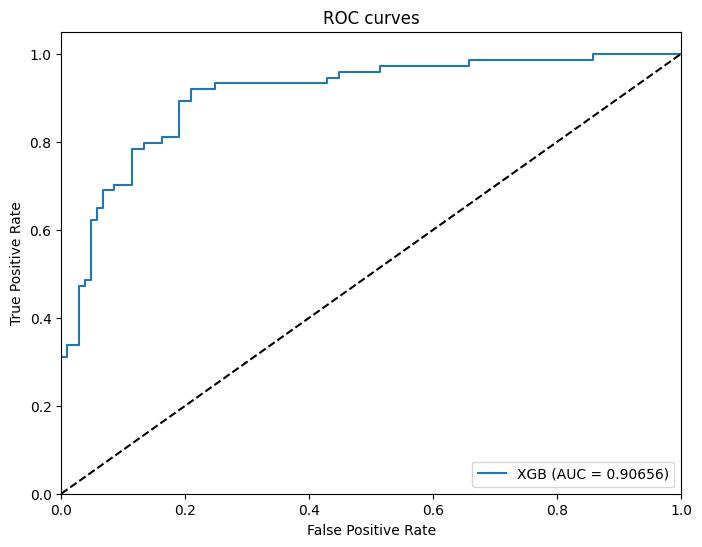

In [32]:
from sklearn.metrics import roc_auc_score,roc_curve
roc = roc_auc_score(y_val, best_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_val, best_proba)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))

plt.plot(fpr_lr, tpr_lr, label='XGB (AUC = %0.5f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

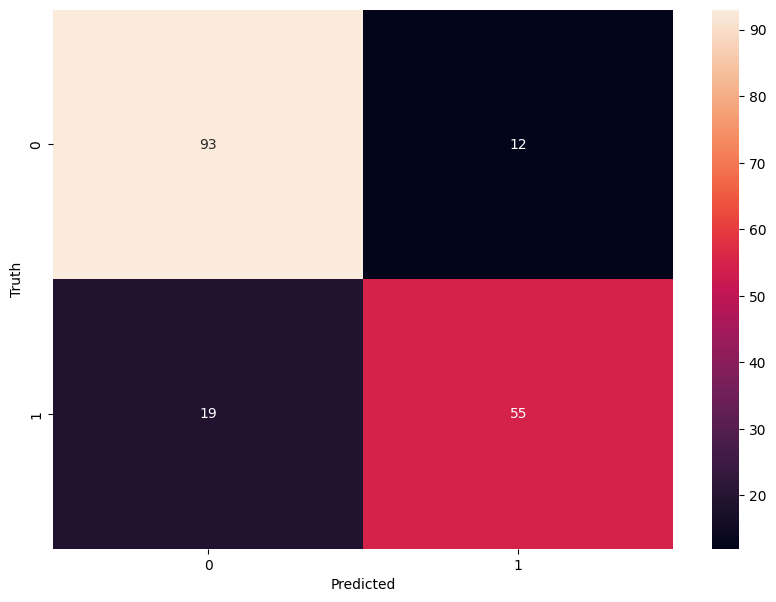

In [33]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_val, predicted)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## 캐글에 제출하기 위한 파일 저장 코드

In [34]:
# test_test = pd.read_csv('test.csv')

In [35]:
# pred = best.predict(X_test)

In [36]:
# submission = pd.DataFrame({
#         "PassengerId": test_test["PassengerId"],
#         "Survived": pred
#     })

In [37]:
# submission.to_csv('titanic_tuned_model.csv',index=False)